# Libraries

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import tree
from sklearn.tree import export_text
from dtreeviz.trees import dtreeviz
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from mlxtend.preprocessing import TransactionEncoder
%matplotlib inline
plt.style.use('seaborn-white')

# Re-Cleaning SASS

In [2]:
## reading and combining initial survey results for public and private school teachers

#reading in initial datasets
pub = pd.read_sas('tchpub99.sas7bdat')
pvt = pd.read_sas('tchpvt99.sas7bdat')

In [3]:
#checking which columns are different between public and private teacher
pubonly = set(pub.columns) - set(pvt.columns)
pvtonly = set(pvt.columns) - set(pub.columns)

#dropping columns not in both
pub.drop(pubonly, axis = 1, inplace = True)
pvt.drop(pvtonly, axis = 1, inplace = True)

#combine public and private school dataframes
sass = pd.concat([pub, pvt])

#drop imputation flags and weights using code here:
begins = ['F_T', 'TREPWT']
sass_clean = sass.loc[:, ~sass.columns.str.startswith(tuple(begins))]
sass_clean = sass_clean.drop('TFNLWGT', axis = 1)

#subset to only full-time teachers
sass_clean = sass_clean[sass_clean.T0051 == 1]
sass_clean = sass_clean.drop('T0051', axis = 1)

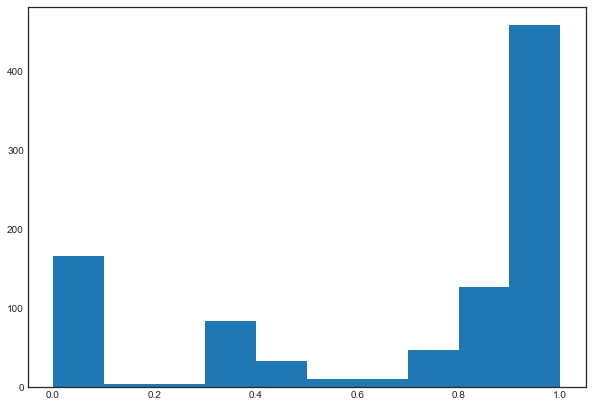

PER
ENRK12UG  0.082318
IEP_T     0.128174
INF_M     0.044109
LEP_T     0.128174
MINENR    0.004266
MINTCH    0.082318
NUMTCH    0.082318
PGMTYPE   0.082318
STU_TCH   0.082318
T0071     0.014521
T0072     0.014521
T0073     0.014521
T0075     0.014521
T0080     0.014521
T0104     0.098473
T0105     0.098473
T0106     0.179339
T0122     0.000023
T0245     0.210741
T0246     0.210741
T0247     0.210741
T0248     0.210741
TRDY      0.128174

In [4]:
## dealing with valid skips

#changing valid skips to missings for easier handling
sass_clean = sass_clean.replace({-8: np.NaN, -9: np.NaN})

#check percentage valid skips for each column
percent_skip = pd.DataFrame(sass_clean.isna().sum()/len(sass_clean))
percent_skip.columns = ["PER"]

# histogram of percent skip
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(percent_skip)
plt.show()

#investigating what variables will be dropped at different missingness thresholds
percent_skip[(percent_skip.PER < 0.3) & (percent_skip.PER > 0)]

In [5]:
#keep only variables with less than 13% skips, any teacher with skips removed
lowskipvar = percent_skip[percent_skip.PER < 0.13].index.values.tolist()
sass_clean = sass_clean[lowskipvar]

#deal with T0104 - T0105
sass_clean['T0104'] = sass_clean['T0104'].replace({None: 0}) #category for uncertified
sass_clean = sass_clean.drop('T0105', axis = 1) #3ntry flag

In [6]:
#columns to be dropped
dropcol = ['SURVEY', #keep sector
           'TEALEV', #keep TEALEV2
           'SCHCNTL', #don't need school number
           'T0064', #same as YRTCHSCH
           'T0207', #entry flag
           'T0070', 'T0071', 'T0072', 'T0073', 'T0075', 'T0080', 'T0083', #education vars
           'T0244', 'T0249', 'T0273', 'T0274', 'T0275', 'T0276', 'T0277', 'T0278', 'T0280', 
           'T0283', 'T0341', 'T0343', 'T0345', 'T0347', 'T0348', 'T0350' #duplicated in summary variables
          ]

#drop columns
sass_clean = sass_clean.drop(dropcol, axis = 1)

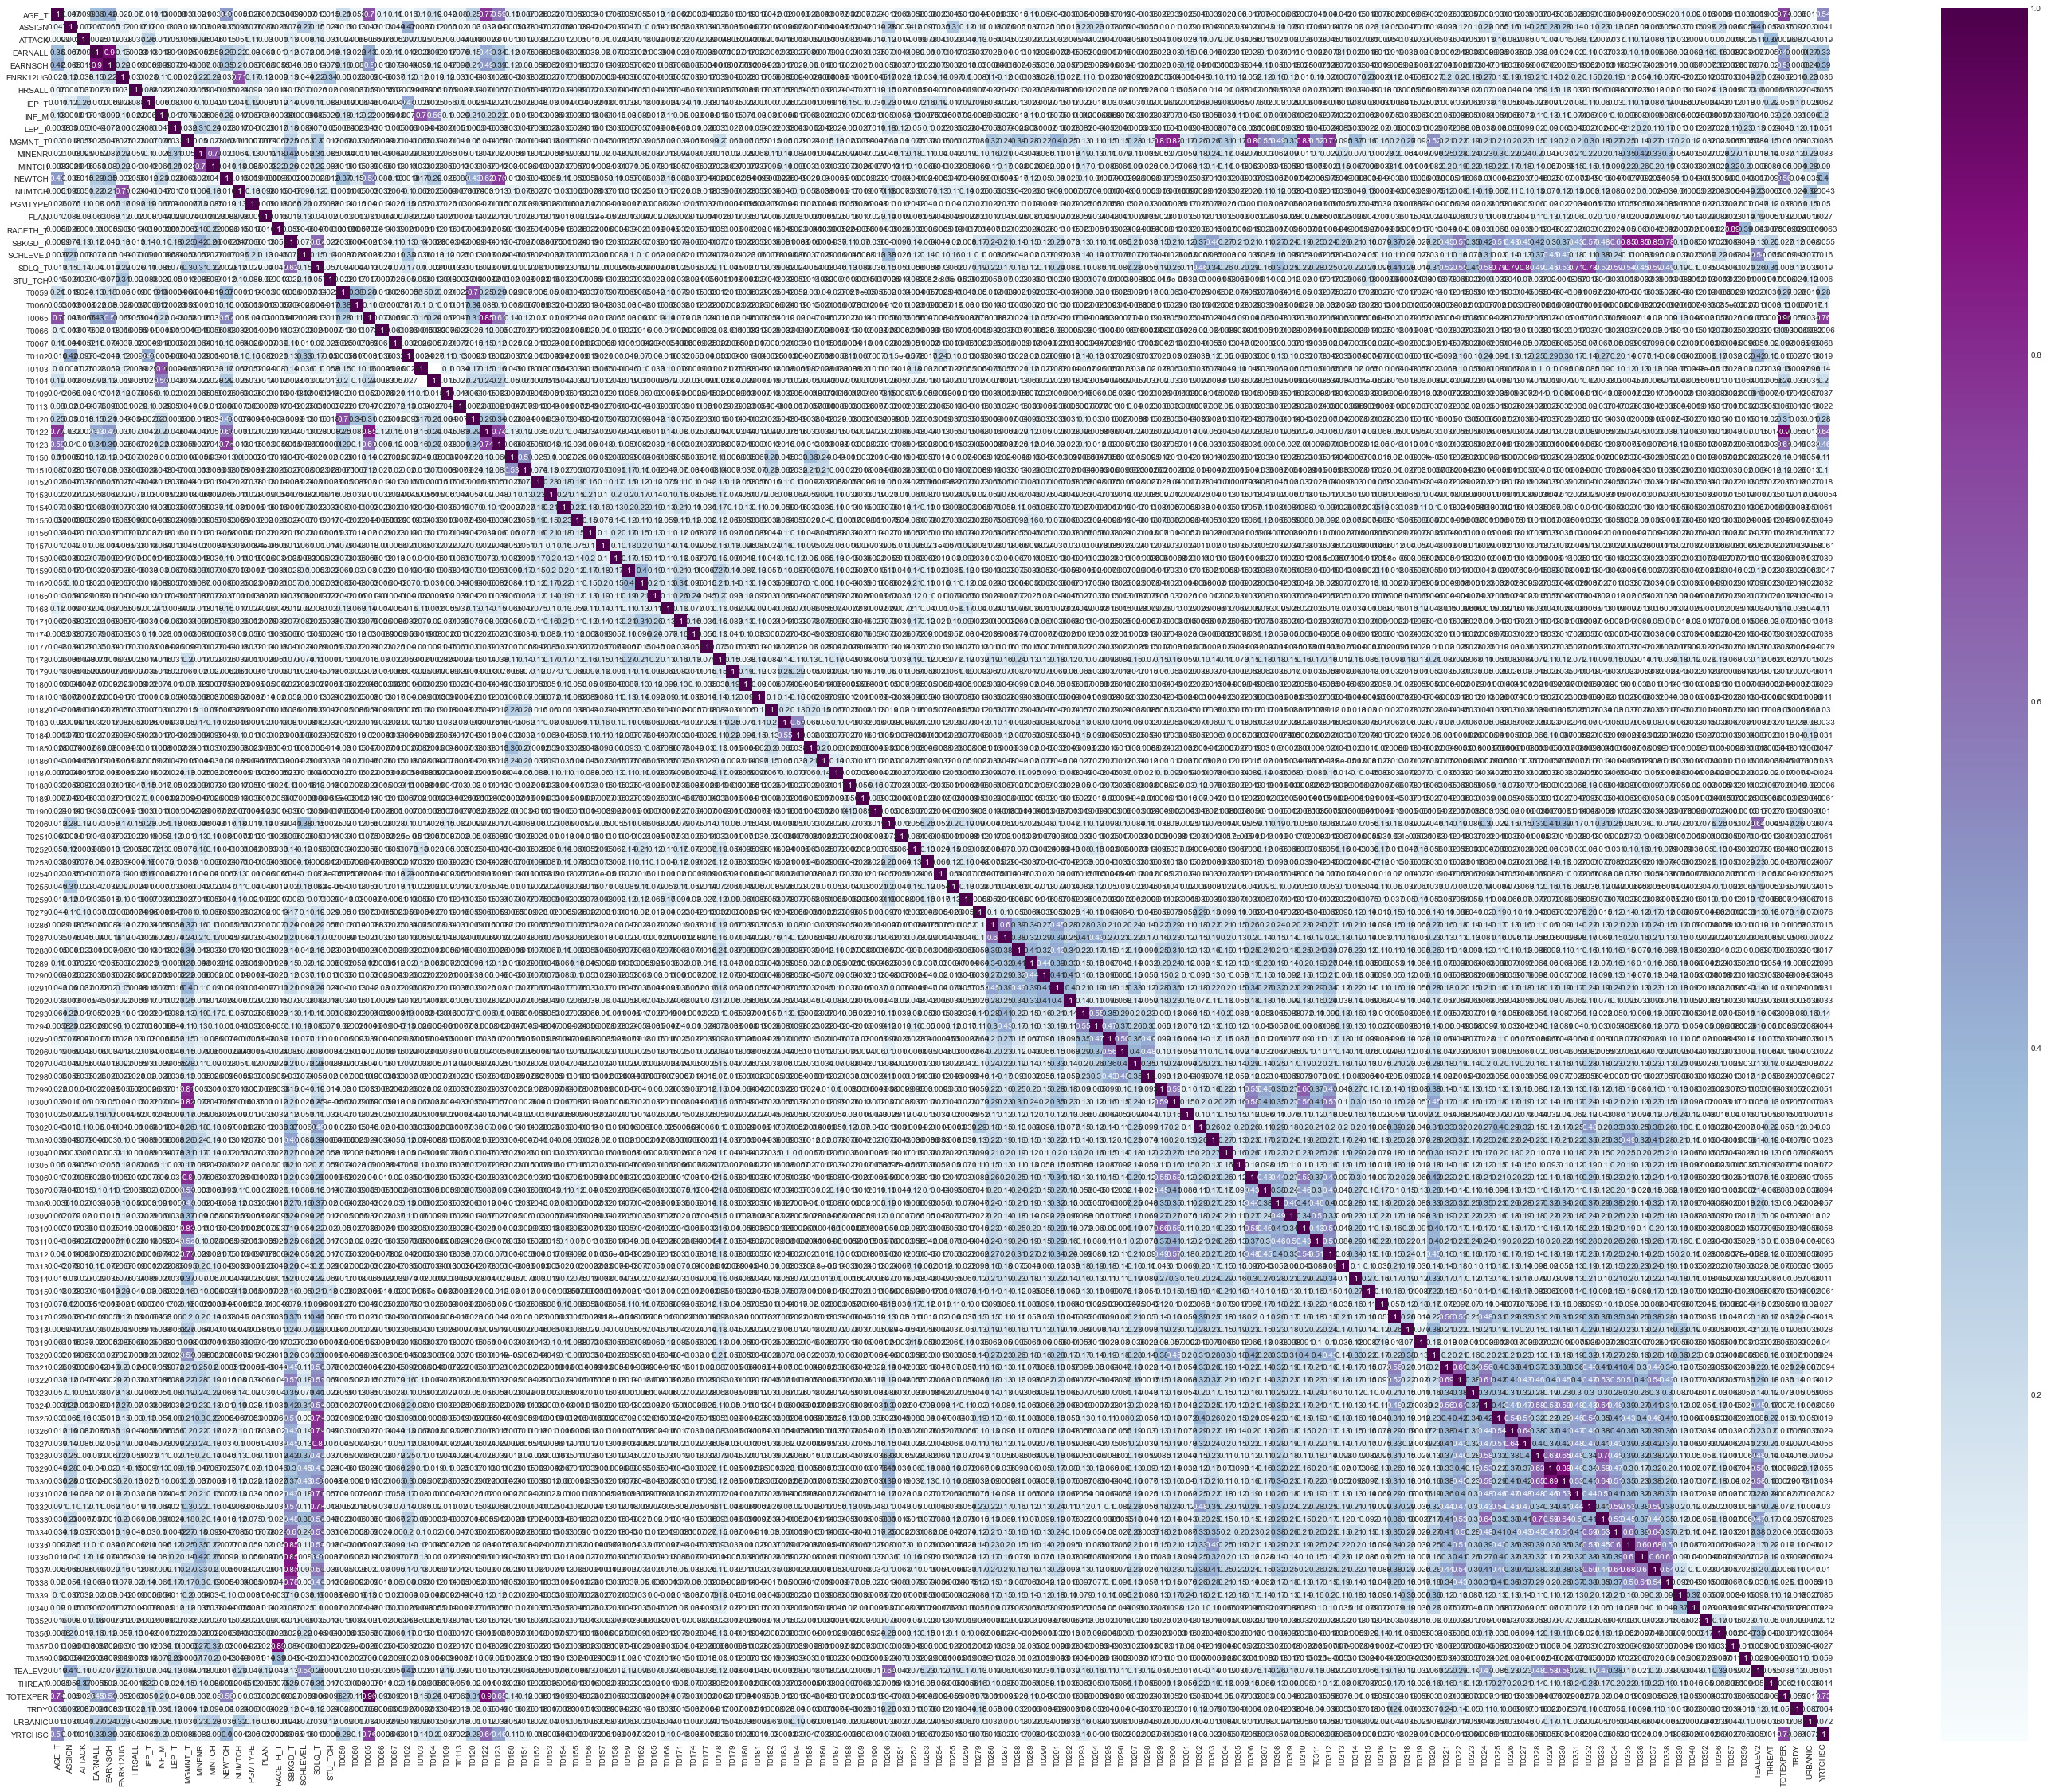

In [7]:
plt.figure(figsize = (50,40))
sns.heatmap(sass_clean.corr().abs(), annot=True, cmap="BuPu")
plt.show()

In [8]:
# Create correlation matrix
corr_mat = sass_clean.corr(method='pearson').abs()
  
# Retain upper triangular values of correlation matrix and
# make Lower triangular values Null
upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values(ascending = False)
print(sorted_mat[sorted_mat > 0.7])

TOTEXPER  T0065       0.959110
EARNSCH   EARNALL     0.903499
TOTEXPER  T0122       0.896752
T0357     RACETH_T    0.892115
T0330     T0329       0.887255
T0337     SBKGD_T     0.852456
T0336     SBKGD_T     0.850691
T0122     T0065       0.848417
T0335     SBKGD_T     0.847936
T0310     MGMNT_T     0.826605
T0300     MGMNT_T     0.824577
T0299     MGMNT_T     0.807085
T0327     SDLQ_T      0.800565
T0306     MGMNT_T     0.795168
T0325     SDLQ_T      0.790362
T0326     SDLQ_T      0.790057
T0332     SDLQ_T      0.776865
T0338     SBKGD_T     0.776048
T0122     AGE_T       0.774256
T0312     MGMNT_T     0.771197
T0123     NEWTCH      0.760623
YRTCHSC   T0065       0.755763
T0123     T0122       0.744765
TOTEXPER  AGE_T       0.737333
YRTCHSC   TOTEXPER    0.733806
T0331     SDLQ_T      0.709107
NUMTCH    ENRK12UG    0.705587
T0120     T0059       0.703403
T0103     INF_M       0.703062
T0333     T0328       0.702046
dtype: float64


Drop based on collinearity: T0122-123, T0065, T0357, EARNALL, T0335 - 338, T0310, T0312, T0299-300, T0325-327, T0332

In [9]:
col_drop = ['T0122', 'T0123', 'T0065', 'T0357', 'EARNALL', 'T0335', 'T0336', 'T0337', 'T0338',
           'T0310', 'T0312', 'T0299', 'T0300', 'T0325', 'T0326', 'T0327', 'T0332']

sass_clean = sass_clean.drop(col_drop, axis = 1)

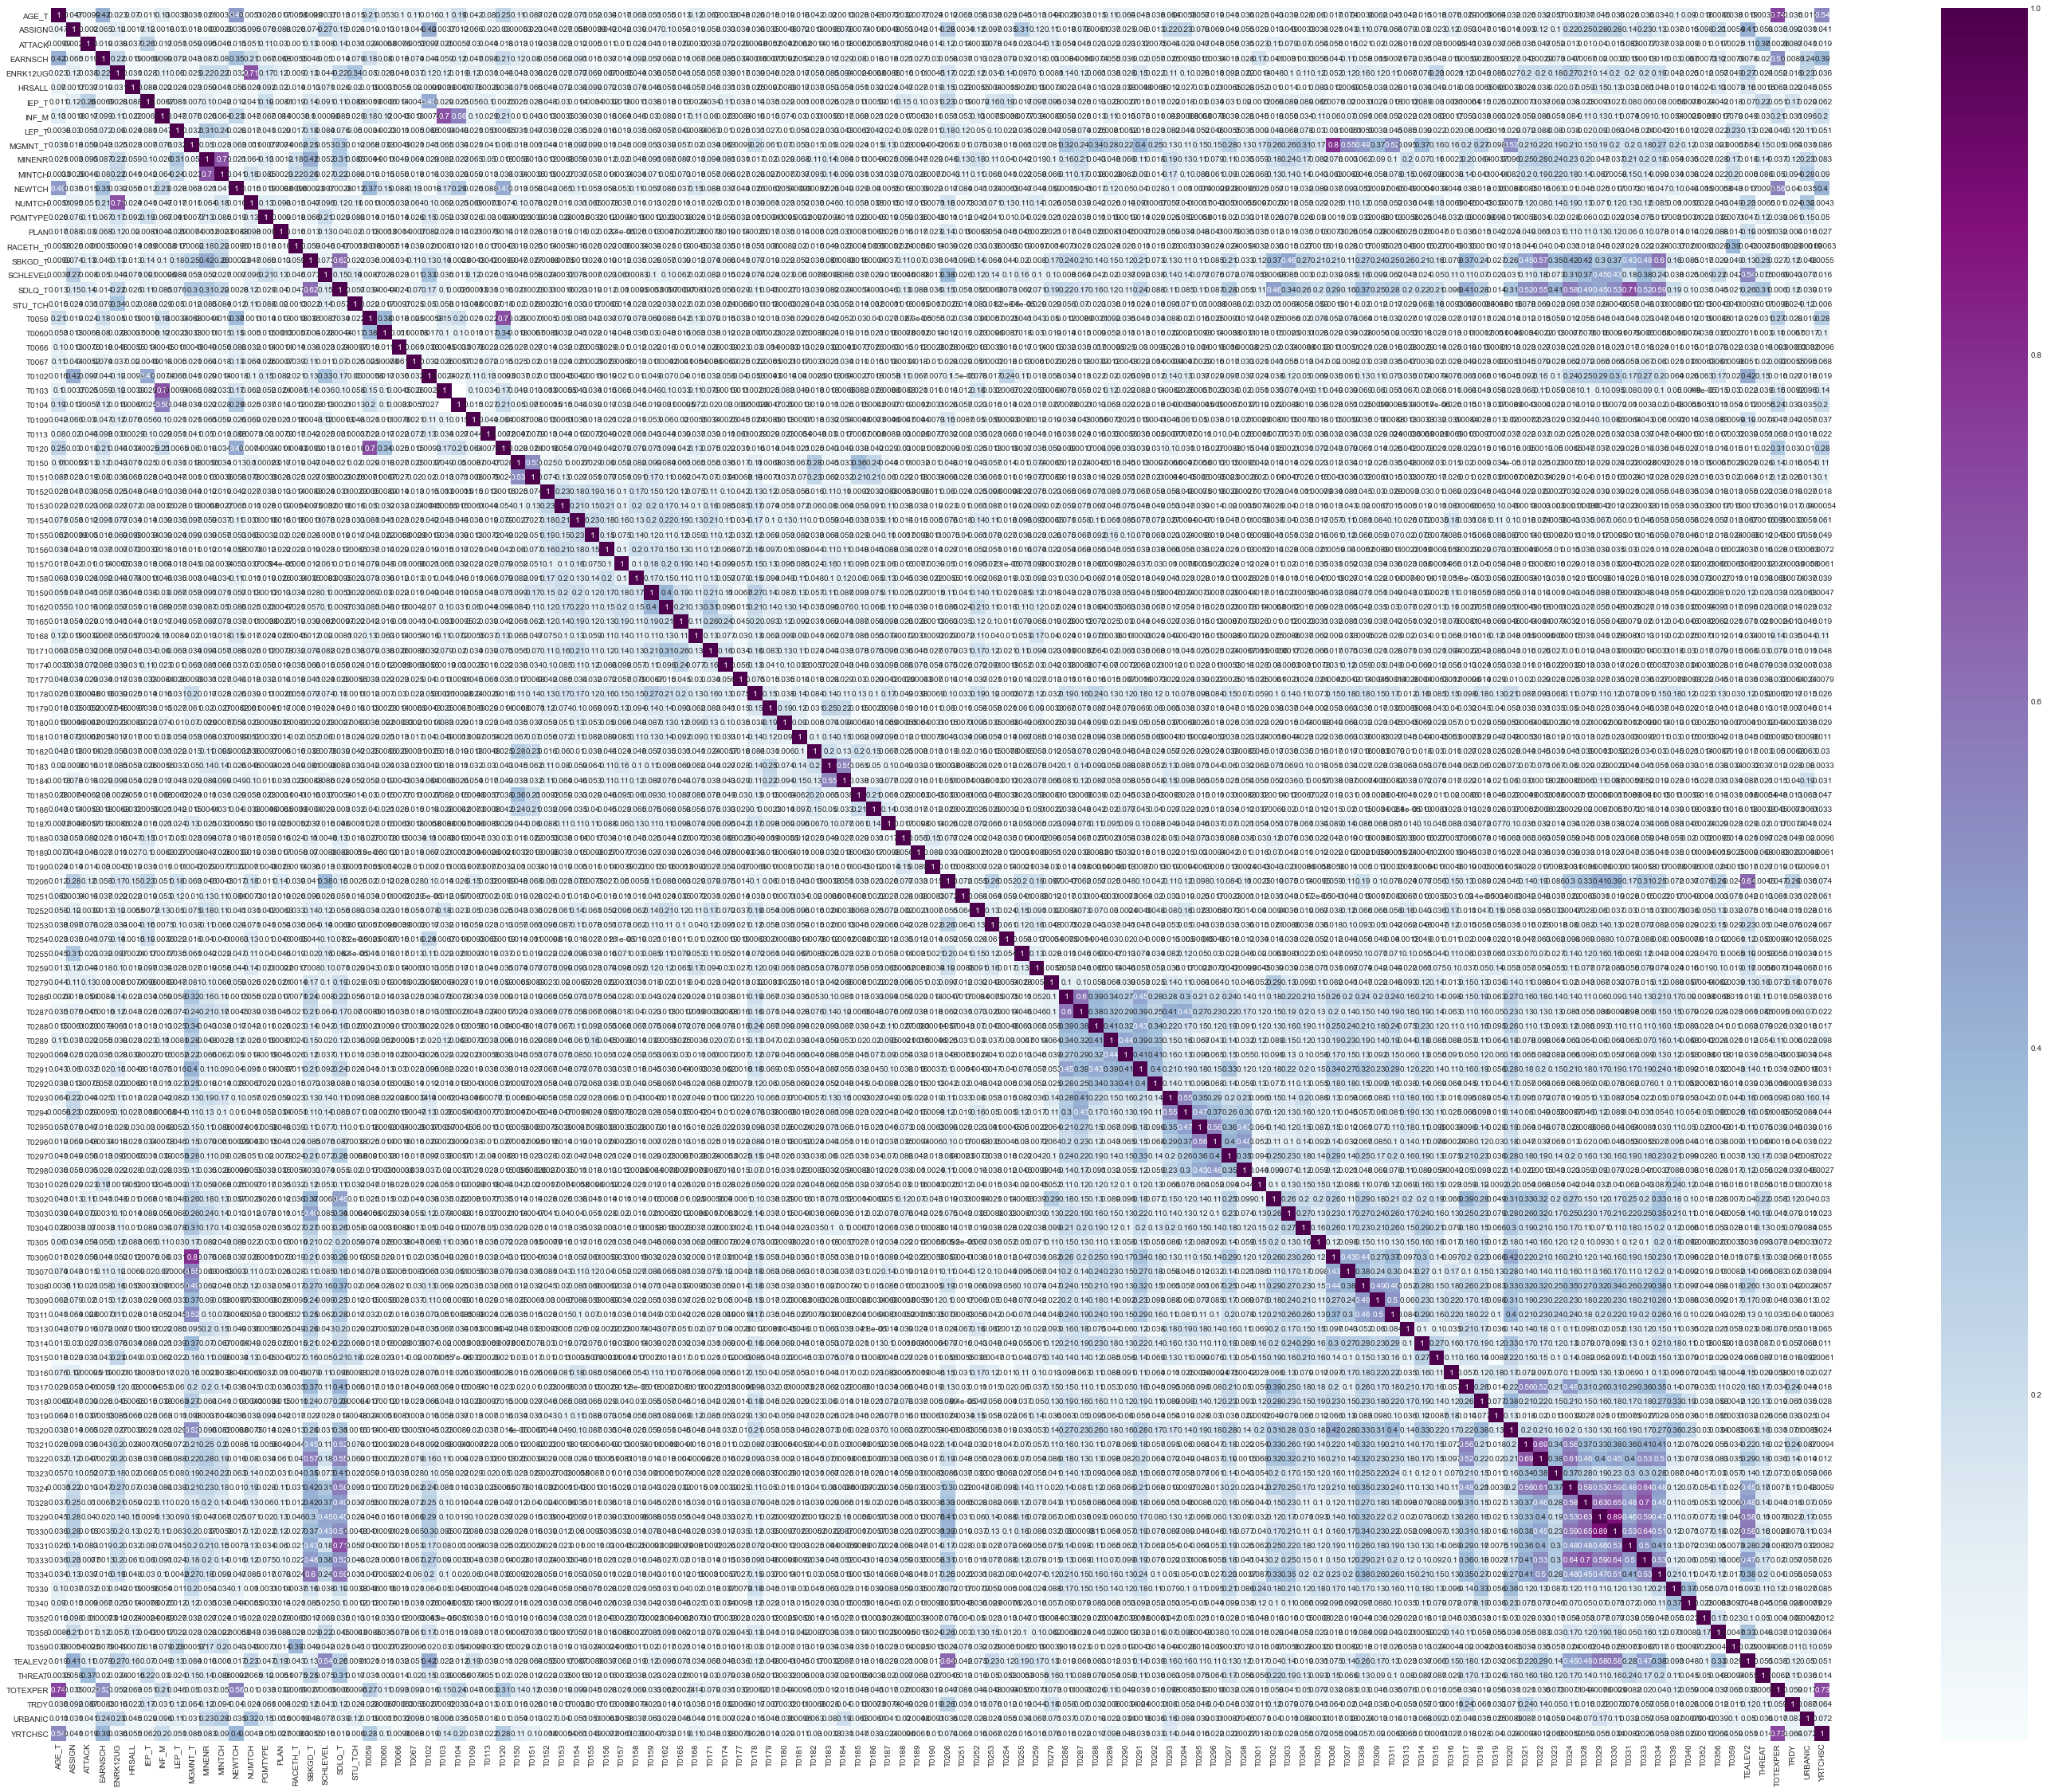

In [10]:
#show after dropping collinear variables
plt.figure(figsize = (50,40))
sns.heatmap(sass_clean.corr().abs(), annot=True, cmap="BuPu")
plt.show()

In [11]:
#remove teachers with missingness
sass_final = sass_clean.dropna()

print("All teachers:", len(sass_clean), 
    "\nTeachers dropped:", len(sass_clean) - len(sass_final))

All teachers: 44073 
Teachers dropped: 13440


# Re-Cleaning TFS

In [12]:
## reading and combining follow-up survey results for leaving and staying teachers

#reading in initial datasets
current = pd.read_sas("crnttchr00.sas7bdat")
former = pd.read_sas("frmrtchr00.sas7bdat")

#checking which columns are different between public and private teacher
curronly = set(current.columns) - set(former.columns)
formonly = set(former.columns) - set(current.columns)

#dropping columns not in both
current.drop(curronly, axis = 1, inplace = True)
former.drop(formonly, axis = 1, inplace = True)

#combine public and private school dataframes
tfs = pd.concat([current, former])

#subset to only full-time teachers
tfs_clean = tfs[tfs.FTPT_S == 1]

#drop imputation flags and weights and some columns repeated from SASS using code here:
#https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe/54410702#54410702
begins = ['F_F', 'TF']
tfs_clean = tfs_clean.loc[:, ~tfs_clean.columns.str.startswith(tuple(begins))]
ends = ['_S', '_T']
tfs_clean = tfs_clean.loc[:, ~tfs_clean.columns.str.endswith(tuple(ends))]

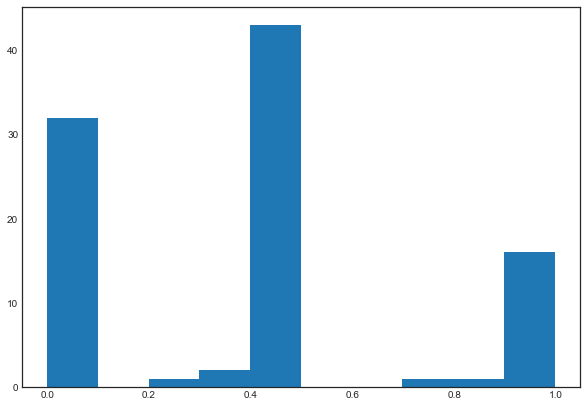

PER
COLBARG   0.398187
ENRK12UG  0.082578
F0051     0.353676
PGMTYPE   0.082578
UNION     0.261631

In [13]:
## dealing with valid skips

#changing valid skips to missings for easier handling
tfs_clean = tfs_clean.replace({-8: np.NaN, -9: np.NaN})

#check percentage valid skips for each column
percent_skip = pd.DataFrame(tfs_clean.isna().sum()/len(tfs_clean))
percent_skip.columns = ["PER"]

# histogram of percent skip
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(percent_skip)
plt.show()

#investigating what variables will be dropped at different missingness thresholds
percent_skip[(percent_skip.PER < 0.4) & (percent_skip.PER > 0)]

In [14]:
#keep all teachers, drop any variable with skips
noskipvar = percent_skip[percent_skip.PER ==0].index.values.tolist()
tfs_clean = tfs_clean[noskipvar]

In [15]:
#drop columns from TFS already covered by SASS dataframe
sassntfs = list(set(sass_final.columns).intersection(set(tfs_clean.columns)))

#remove primary key from list of redundant columns 
sassntfs.remove('CNTLNUM')

#remove redundant columns
tfs_clean = tfs_clean.drop(sassntfs, axis = 1)
print(set(sass_final.columns).intersection(set(tfs_clean.columns)))

{'CNTLNUM'}


In [16]:
#drop some redundant vars
tfs_clean.drop(['AGE_TT', 'F0188', 'SURVEY', 'STATUS', 'SCHCNTL'], axis = 1, inplace = True)
sass_final = sass_final.drop(['T0356', #Gender M/F
                  'T0359', #Hispanic
                 'RACETH_T', 
                 'T0159', 'T0162', 'T0165', 'T0168', 'T0171', 'T0174', 'T0177' #PD binaries
                ], axis = 1)

#remove teachers with missingness
tfs_final = tfs_clean.dropna()

print("All teachers:", len(tfs_clean), 
    "\nTeachers dropped:", len(tfs_clean) - len(tfs_final))

All teachers: 4965 
Teachers dropped: 0


# Merging Datasets

In [17]:
#merge SASS and TFS on CNTLNUM
all_data = sass_final.merge(tfs_final, how = 'inner', on = 'CNTLNUM')
all_data.drop('CNTLNUM', axis = 1, inplace = True)
print("Original TFS teachers:", len(tfs_final))
print("Teachers lost:", len(tfs_final) - len(all_data))
print("Teachers kept:", len(all_data))
print("Columns:", all_data.columns.values.tolist())
print("Number of Columns:", len(all_data.columns))

Original TFS teachers: 4965
Teachers lost: 1761
Teachers kept: 3204
Columns: ['AGE_T', 'ASSIGN', 'ATTACK', 'EARNSCH', 'ENRK12UG', 'HRSALL', 'IEP_T', 'INF_M', 'LEP_T', 'MGMNT_T', 'MINENR', 'MINTCH', 'NEWTCH', 'NUMTCH', 'PGMTYPE', 'PLAN', 'REGION', 'SBKGD_T', 'SCHLEVEL', 'SDLQ_T', 'SECTOR', 'STU_TCH', 'T0059', 'T0060', 'T0066', 'T0067', 'T0102', 'T0103', 'T0104', 'T0109', 'T0113', 'T0120', 'T0150', 'T0151', 'T0152', 'T0153', 'T0154', 'T0155', 'T0156', 'T0157', 'T0158', 'T0178', 'T0179', 'T0180', 'T0181', 'T0182', 'T0183', 'T0184', 'T0185', 'T0186', 'T0187', 'T0188', 'T0189', 'T0190', 'T0206', 'T0251', 'T0252', 'T0253', 'T0254', 'T0255', 'T0259', 'T0279', 'T0286', 'T0287', 'T0288', 'T0289', 'T0290', 'T0291', 'T0292', 'T0293', 'T0294', 'T0295', 'T0296', 'T0297', 'T0298', 'T0301', 'T0302', 'T0303', 'T0304', 'T0305', 'T0306', 'T0307', 'T0308', 'T0309', 'T0311', 'T0313', 'T0314', 'T0315', 'T0316', 'T0317', 'T0318', 'T0319', 'T0320', 'T0321', 'T0322', 'T0323', 'T0324', 'T0328', 'T0329', 'T0330

# Dealing with datatype and binary coding issues

In [18]:
#list of binary variables
bin = ['NEWTCH', 'T0060', 'T0067', 'T0083', 'T0109', 'T0103', 'T0113', 'T0150', 
           'T0151', 'T0152', 'T0153', 'T0154', 'T0155', 'T0156', 'T0157', 'T0158',
            'T0182', 'T0185', 'T0186', 'T0187', 'T0251', 'T0259', 
          'T0179', 'T0180', 'T0181', 'T0182', 'T0183', 'T0184', 'T0185', 'T0186', 'T0187', 
          'T0251', 'T0253', 'T0254', 'T0255', 'T0259', 'F0050', 'F0154', 'GENDER' ]

bin_idx = all_data.columns.get_indexer(bin).tolist()           
all_data.iloc[:, bin_idx] = all_data.iloc[:, bin_idx].replace({2:0})

#normalize ordinal and continuous variables
tonorm = ['AGE_T', 'ENRK12UG','EARNSCH', 'HRSALL', 'IEP_T', 'LEP_T', 'MGMNT_T', 'MINENR', 'MINTCH', 'NUMTCH', 'PLAN',  
          'SBKGD_T', 'SDLQ_T','STU_TCH', 'T0066', 'T0178','T0279', 'T0252', 'T0286', 'T0287', 'T0288', 'T0289', 'T0290', 'T0291', 
          'T0292', 'T0293', 'T0294', 'T0295', 'T0296', 'T0297', 'T0298', 'T0301', 'T0302', 'T0303', 'T0304', 
          'T0305', 'T0306', 'T0307', 'T0308', 'T0309', 'T0311', 'T0313', 'T0314', 'T0315', 'T0316', 'T0317', 
          'T0318', 'T0319', 'T0320', 'T0321', 'T0322', 'T0323', 'T0324', 'T0328', 'T0329', 'T0330', 'T0331', 
          'T0333', 'T0334', 'T0339', 'TOTEXPER', 'TRDY', 'URBANIC', 'YRTCHSC', 
          'F0194', 'F0196', 'F0197', 'HIDEGREE', 'PD_CPTR', 'PD_DISC', 'PD_MTHD', 'PD_STAS', 'PD_STDS', 'PD_SUBJ']

all_data[tonorm] = StandardScaler().fit_transform(all_data[tonorm])
           
#categorical variables
cat = ['ATTACK', 'THREAT', 'ASSIGN', 'PGMTYPE', 'RACE', 'REGION', 'SCHLEVEL', 'INF_M', 'T0059', 'T0102', 'T0104', 
      'T0188', 'T0189', 'T0190', 'T0206', 'T0340', 'TEALEV2', 'SECTOR', 'T0120', 'F0166', 'F0195', 'RACE']

nocat_data = all_data.drop(cat, axis = 1)

In [36]:
nocat_data

AGE_T   EARNSCH  ENRK12UG    HRSALL     IEP_T     LEP_T   MGMNT_T  \
0     1.180267  0.708814 -1.512215  0.019735  0.068222 -0.337363 -1.733037   
1     1.180267 -1.266863 -1.512215 -1.220095  3.571395 -0.337363  1.220215   
2     0.337106 -0.279024  0.838652 -1.783655 -0.529515 -0.291721  0.414783   
3    -1.349214 -1.266863 -0.336781 -0.205689 -0.194849 -0.337363  0.414783   
4    -0.506054 -0.279024  0.838652 -0.656536 -0.405472 -0.062278  0.146305   
...        ...       ...       ...       ...       ...       ...       ...   
3199  1.180267 -0.279024 -1.512215 -2.009078 -0.591120 -0.337363  0.414783   
3200  1.180267  1.696653  0.838652 -1.107383 -0.591120 -0.337363  1.220215   
3201  1.180267 -0.279024 -1.512215  0.357871 -0.495382 -0.337363  0.146305   
3202 -1.349214 -0.279024 -1.512215 -1.332807 -0.591120 -0.337363  0.951737   
3203  0.337106 -0.279024  0.838652 -0.092977 -0.591120 -0.337363  0.951737   

        MINENR    MINTCH  NEWTCH  ...     F0196     F0197  GENDER  HIDEGREE  \
0    -0.239788 -1.090904     0.0  ...  1.957266 -0.387200     1.0 -0.744008   
1     0.648399  0.496766     1.0  ...  0.551982 -0.387200     0.0  2.440765   
2     0.648399 -1.090904     0.0  ... -0.853302 -0.387200     0.0 -0.744008   
3    -1.127976 -1.090904     0.0  ...  3.362550  5.053979     0.0 -0.744008   
4    -0.239788 -0.297069     0.0  ... -0.853302 -0.387200     0.0 -0.744008   
...        ...       ...     ...  ...       ...       ...     ...       ...   
3199 -1.127976 -1.090904     0.0  ... -0.853302 -0.387200     0.0 -2.336395   
3200 -1.127976 -0.297069     0.0  ...  1.254624 -0.387200     1.0  0.848378   
3201 -1.127976 -1.090904     0.0  ... -0.853302 -0.387200     0.0 -0.744008   
3202 -1.127976 -0.297069     1.0  ... -0.150660  1.426526     0.0 -0.744008   
3203 -1.127976 -0.297069     0.0  ...  1.254624 -0.387200     0.0 -0.744008   

       PD_CPTR   PD_DISC   PD_MTHD   PD_STAS   PD_STDS   PD_SUBJ  
0    -0.167318  0.478465 -1.046475 -0.833799  0.525445  0.478774  
1    -0.167318 -0.657934 -0.227695  0.144770  1.293828 -0.847061  
2    -1.003648 -0.657934  2.228648  0.144770 -1.011320  1.804608  
3    -1.003648 -0.657934 -1.046475  0.144770 -0.242937 -0.184144  
4    -0.167318 -0.657934 -1.046475  0.144770 -1.011320 -0.847061  
...        ...       ...       ...       ...       ...       ...  
3199 -1.003648 -0.657934 -1.046475  0.144770 -1.011320 -0.847061  
3200 -1.003648 -0.657934 -0.227695 -0.833799 -0.242937  1.141691  
3201 -0.167318  0.478465  0.591086  0.144770 -1.011320 -0.847061  
3202 -1.003648 -0.657934 -1.046475 -0.833799 -0.242937 -0.847061  
3203  0.669012 -0.657934 -0.227695 -0.833799 -0.242937 -0.184144  

[3204 rows x 107 columns]

# Data Exploration

Text(0.5, 1.0, 'Histogram of Teacher Reported Satisfaction')

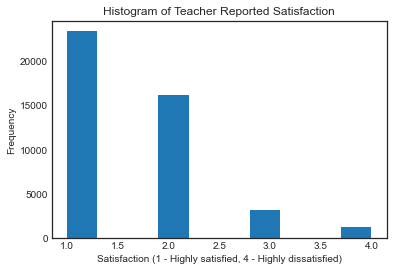

In [35]:
plt.hist(x = "T0320", data = sass_clean) #histogram of target variable
plt.xlabel("Satisfaction (1 - Highly satisfied, 4 - Highly dissatisfied)")
plt.ylabel("Frequency")
plt.title("Histogram of Teacher Reported Satisfaction")

# Data Analysis

In [21]:
#split into x and y
x = nocat_data[nocat_data.columns.difference(['T0320'])] # include only non-categorical data and exclude target
y = nocat_data['T0320']

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.20, #80% training, 20% testing
                                                    random_state=1)

### Ridge Regression

Best CV error:  0.5619753855353922
Best alpha:  0.20970464013232348


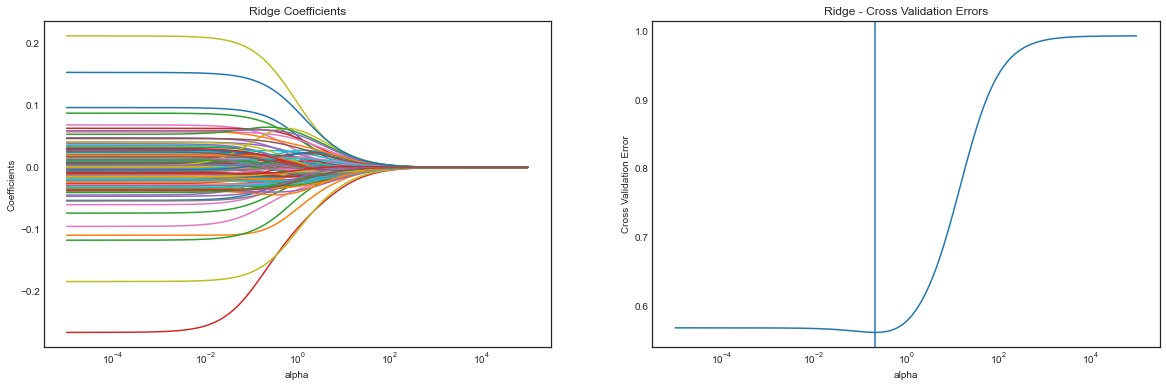

In [22]:
#tunning ridge
model_ridge = Ridge(normalize = True)
coefs = []
cv_errors_ridge = []

alphas = np.logspace(-5, 5, 200)
for a in alphas:
    model_ridge.set_params(alpha=a) #setting alpha
    model_ridge.fit(x_train, y_train)
    coefs.append(model_ridge.coef_) #add coefs for a as alpha
    cross_val = cross_val_score(model_ridge, x_train, y_train, cv = 10, 
                                scoring='neg_mean_squared_error') #cv error for ridge with alpha a, 10 groups
    cv_errors_ridge.append(np.mean(abs(cross_val)))

plt.figure(figsize=(20, 6))
    
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()  
ax.plot(alphas, cv_errors_ridge)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Cross Validation Error')
plt.title('Ridge - Cross Validation Errors')
plt.axis('tight')

min_val_ridge = min(cv_errors_ridge) #minimum error
i = cv_errors_ridge.index(min_val_ridge) #index of minimum error
plt.axvline(alphas[i]) #corresponding alpha value
print("Best CV error: ", min_val_ridge)
print("Best alpha: ", alphas[i])

In [23]:
#tunded model
ridge_tuned = Ridge(normalize = True).set_params(alpha = alphas[i]).fit(x_train,y_train) #fit to training

#training metrics
print("Train R-Squared: ", np.mean(cross_val_score(ridge_tuned, x_train, y_train, cv = 10, scoring='r2'))) #r-squared
print("Train CV Error: ", abs(np.mean(cross_val_score(ridge_tuned, x_train, y_train, cv = 10, 
                                                  scoring='neg_mean_squared_error')))) #cv error

#testing metrics
print("Test R-Squared: ", np.mean(cross_val_score(ridge_tuned, x_test, y_test, cv = 10, scoring='r2'))) #r-squared
print("Test CV Error: ", abs(np.mean(cross_val_score(ridge_tuned, x_test, y_test, cv = 10, 
                                                 scoring='neg_mean_squared_error')))) #cv error


Train R-Squared:  0.426839717723158
Train CV Error:  0.5619753855353922
Test R-Squared:  0.3896685472300561
Test CV Error:  0.6102672617957097


The ridge regression did the best with an alpha of 0.2097. The training data set had a cross-validation error of 0.5620 and an r-sqaured of 0.4269, meaning the model predicted about 43% of the variation in the data. The testing data set had a cross-validation error of 0.6103 and an r-squared of 0.3897. The model performed slightly worse with the testing set, but not to the extent to indicate overfitting.

Overall, the model did not perform well. It predicted teacher satisfaction less accurately than a coin flip.

### Lasso Regression

Best CV error:  0.5583171175636389
Best alpha:  0.000286606761694825


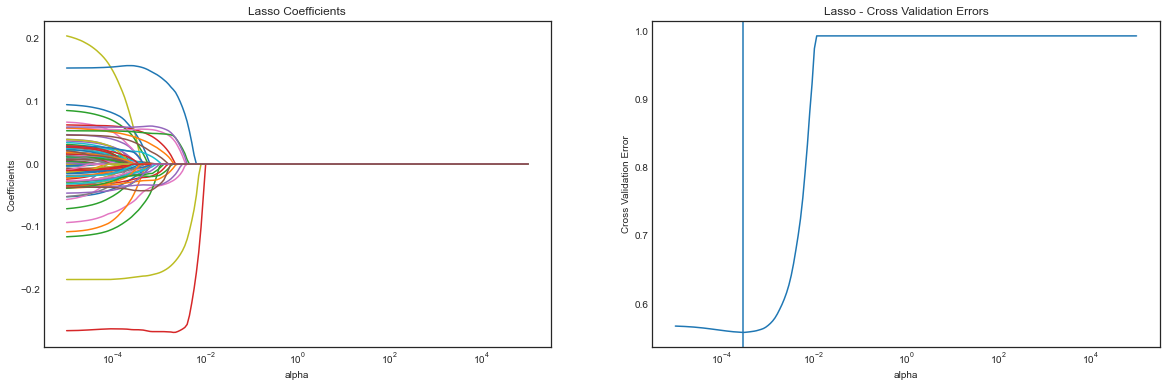

In [24]:
#tuning lasso
model_lasso = Lasso(normalize = True)
coefs = []
cv_errors_lasso = []

alphas = np.logspace(-5, 5, 200)
for a in alphas:
    model_lasso.set_params(alpha=a) #setting alpha
    model_lasso.fit(x_train, y_train)
    coefs.append(model_lasso.coef_) #add coefs for a as alpha
    cross_val = cross_val_score(model_lasso, x_train, y_train, cv = 10, 
                                scoring='neg_mean_squared_error') #cv error for lasso with alpha a, 10 groups
    cv_errors_lasso.append(np.mean(abs(cross_val)))

plt.figure(figsize=(20, 6))
    
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()  
ax.plot(alphas, cv_errors_lasso)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Cross Validation Error')
plt.title('Lasso - Cross Validation Errors')
plt.axis('tight')

min_val_lasso = min(cv_errors_lasso) #minimum error
i = cv_errors_lasso.index(min_val_lasso) #index of minimum error
plt.axvline(alphas[i]) #corresponding alpha value
print("Best CV error: ", min_val_lasso)
print("Best alpha: ", alphas[i])

In [25]:
#tuned model
lasso_tuned = Lasso(normalize = True, tol=1e-2).set_params(alpha = alphas[i]).fit(x_train,y_train) #fit to training
#(tol =) is to prevent converging error

#training metrics
print("Train R-Squared: ", np.mean(cross_val_score(lasso_tuned, x_train, y_train, cv = 10, scoring='r2'))) #r-squared
print("Train CV Error: ", abs(np.mean(cross_val_score(lasso_tuned, x_train, y_train, cv = 10, 
                                                  scoring='neg_mean_squared_error')))) #cv error

#testing metrics
print("Test R-Squared: ", np.mean(cross_val_score(lasso_tuned, x_test, y_test, cv = 10, scoring='r2'))) #r-squared
print("Test CV Error: ", abs(np.mean(cross_val_score(lasso_tuned, x_test, y_test, cv = 10, 
                                                 scoring='neg_mean_squared_error')))) #cv error

Train R-Squared:  0.43027271446059306
Train CV Error:  0.5583562678660285
Test R-Squared:  0.38457047394458505
Test CV Error:  0.6140225129831984


The lasso regression did the best with an alpha of 0.0003, smaller than the ridge regression. The training data set had a cross-validation error of 0.5584 and an r-sqaured of 0.4303, meaning the model predicted about 43% of the variation in the data. The testing data set had a cross-validation error of 0.6140 and an r-squared of 0.3846. The model performed slightly worse with the testing set, but not to the extent to indicate overfitting.

Overall, the model did not perform well. It predicted teacher satisfaction less accurately than a coin flip.

### Random Forests

In [26]:
#tuning rf
param_grid = {
    'max_depth': [10, 25, 50],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 250, 500]
} #parameters to try
rf = RandomForestRegressor() #load random forests
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10) #set up grid search

grid_search.fit(x_train, y_train) #fit grid search with training data
grid_search.best_params_ #print best params

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}

In [27]:
#tuned model
tree = RandomForestRegressor(random_state=1, max_depth = 25, max_features = 'sqrt', n_estimators = 500) #run rfr with best params
tree.fit(x_train, y_train) #fit to training data

#training metrics
cv_scores = cross_val_score(tree, x_train, y_train, cv=10, scoring='neg_mean_squared_error') #cv error
r = cross_val_score(tree, x_train, y_train, cv=10, scoring='r2') #r-squared
print("Train CV Error: ", abs(np.mean(cv_scores)))
print("Train R-Squared: ", np.mean(r))

#testing metrics
cv_scores1 = cross_val_score(tree, x_test, y_test, cv=10, scoring='neg_mean_squared_error') #cv error
r1 = cross_val_score(tree, x_test, y_test, cv=10, scoring='r2') #r-squared
print("Test CV Error: ", abs(np.mean(cv_scores1)))
print("Test R-Squared: ", np.mean(r1))

Train CV Error:  0.5980768794717781
Train R-Squared:  0.3914363372575818
Test CV Error:  0.6226236664538194
Test R-Squared:  0.38633044120992677


The random forest model did the best with a max depth of 25, the square root of predictors as the maximum number of predictors, and 500 trees. The training data set had a cross-validation error of 0.5981 and an r-sqaured of 0.3914, meaning the model predicted less than 40% of the variation in the data. The testing data set had a cross-validation error of 0.6226 and an r-squared of 0.3863. The model performed slightly worse with the testing set, but not to the extent to indicate overfitting.

Overall, the model did not perform well. It predicted teacher satisfaction less accurately than a coin flip.

# Conclusions and Discussions

Overall, none of the models that I tried performed very well. They all had an r-squared less than 0.50. Even after tuning the models, the highest r-squared I was able to get on the training data was 0.43. This was disapointing, but it is what can happen when you work with real world data. The ridge and lasso regressions had very similar performance metrics, but ridge slighly outperformed lasso when it came to the testing cross-validation error and r-squared. 

The conclusion from this analysis is that it can be difficult to predict teacher satisfaction. This may be because the data were based on self-reported surveys. Additionally, the histogram of the target variable showed that most teachers reported the same rating for satisfaction. It's possible that so many teachers inputting the same entry made it difficult to predict satisfaction based on teachers' traits.

# Future Work

We tried to run a linear regression with feature selection, however, my computer did not have the CPU power to be able to complete this kind of analysis. If I had access to a more powerful computer, I would be curious if certain predictors were more likely to predict teacher satisfaction than others.

I would also want to use a dimension reduction algorithm on this dataset. This would likely make it easier to run models on the data. I attempted this, but unfortunately I was unable to debug the code to make it work for these data.

I would also be curious if we could find more recent data to attempt a similar analysis. As these data are from 1999-2001, it is very difficult to make any statements about the current school system and teacher labor force.

# Sources

https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe/54410702#54410702

https://blog.finxter.com/python-string-startswith-how-to-test-multiple-values/

https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/

https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge

https://medium.com/analytics-vidhya/lasso-regression-fundamentals-and-modeling-in-python-ad8251a636cd

Homeworks 1, 2, 3

Labs 1, 2, 3